## load libraries

In [ ]:
library(here)
library(stringr)
library(dplyr)
library(ggplot2)
library(Seurat)
library(purrr)
library(readr)
library(patchwork)
library(scCustomize)
library(tidyverse)
library(reticulate)
library(harmony)
library(glmGamPoi)
library(presto)
library(EnhancedVolcano)

## load data

In [ ]:
# Load raw files as count matrix
counts <- Read10X_GEO(
    data_dir = here("data")
)

Reading 10X files from directory


In [ ]:
# fix prefix
for (sample in names(counts)) {
    colnames(counts[[sample]]) <- gsub("^2_", "", colnames(counts[[sample]]))
}

In [ ]:
# Create Seurat object for each sample
control_seurat <- CreateSeuratObject(
    counts = counts$GSM8494123_control_, 
    project = "control"
)
high_glucose_seurat <- CreateSeuratObject(
    counts = counts$GSM8494124_high_glucose_, 
    project = "high_glucose"
)

# Merge seurat objects
merged_seurat <- merge(
    x = control_seurat, 
    y = high_glucose_seurat, 
    add.cell.ids = c("control", "high_glucose")
)

merged_seurat


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class dgTMatrix. Coercing to dgCMatrix.”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class dgTMatrix. Coercing to dgCMatrix.”


An object of class Seurat 
32521 features across 15863 samples within 1 assay 
Active assay: RNA (32521 features, 0 variable features)
 2 layers present: counts.control, counts.high_glucose

## quality control metrics

In [ ]:
# calculate qc metrics
merged_seurat[["log1p_nCount_RNA"]] <- log1p(merged_seurat@meta.data$nCount_RNA)

merged_seurat[["log1p_nFeature_RNA"]] <- log1p(merged_seurat@meta.data$nFeature_RNA)

merged_seurat[["pct_counts_in_top_20_genes"]] <- apply(
  as.matrix(GetAssayData(object = merged_seurat, assay = "RNA", layer = "counts.control")),
  MARGIN = 2, 
  FUN = function(x) {
    sum(sort(x, decreasing = TRUE)[1:20]) / sum(x) * 100
  }
)

merged_seurat[["pct_counts_in_top_20_genes"]] <- apply(
  as.matrix(GetAssayData(object = merged_seurat, assay = "RNA", layer = "counts.high_glucose")),
  MARGIN = 2,  
  FUN = function(x) {
    sum(sort(x, decreasing = TRUE)[1:20]) / sum(x) * 100
  }
)

merged_seurat[["pct_counts_mt"]] <- PercentageFeatureSet(merged_seurat, pattern = "^mt-")


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.4 GiB”


## filter low quality cells

With adaptive thresholds


FALSE  TRUE 
14469  1394 


FALSE  TRUE 
 8818  7045 

Total cells before filtering: 15863 
Total cells after filtering: 8740 


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


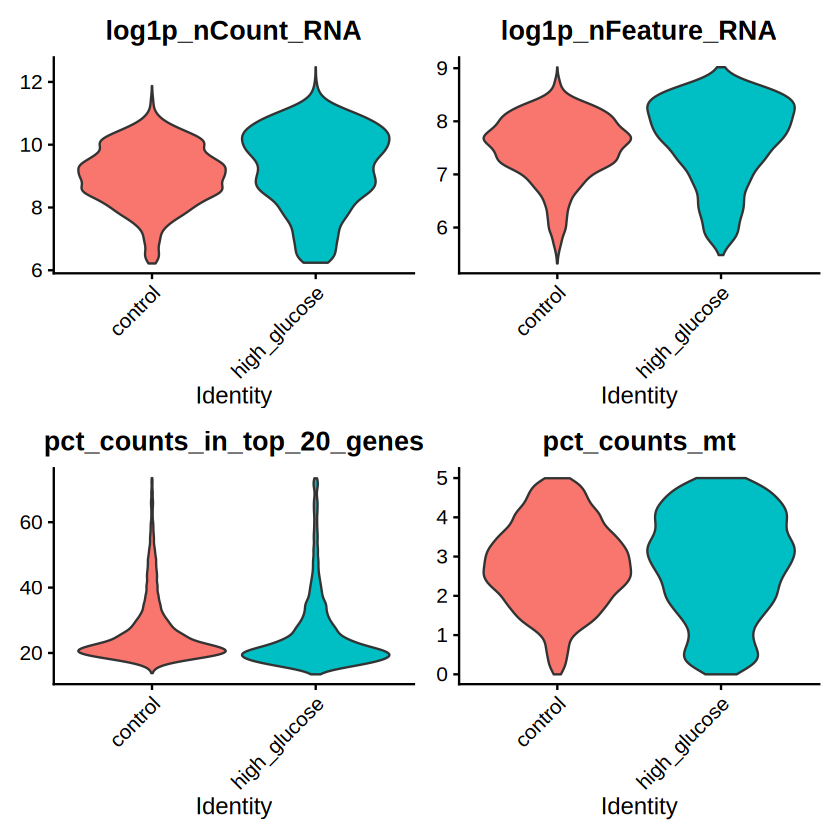

In [ ]:
is_outlier <- function(data, metric, nmads) {
  M <- data[[metric]]
  outlier <- (M < median(M, na.rm = TRUE) - nmads * mad(M, na.rm = TRUE)) |
             (M > median(M, na.rm = TRUE) + nmads * mad(M, na.rm = TRUE))
  return(outlier)
}

# Apply the function to detect outliers in QC metrics
merged_seurat@meta.data$outlier <- (
  is_outlier(merged_seurat@meta.data, "log1p_nCount_RNA", 3) |
  is_outlier(merged_seurat@meta.data, "log1p_nFeature_RNA", 3)|
  is_outlier(merged_seurat@meta.data, "pct_counts_in_top_20_genes", 3)
)

# Apply the function for mitochondrial percentage with a stricter threshold
merged_seurat@meta.data$mt_outlier <- (
  is_outlier(merged_seurat@meta.data, "pct_counts_mt", 3) |
  (merged_seurat@meta.data$pct_counts_mt > 5)
)

table(merged_seurat@meta.data$outlier)
table(merged_seurat@meta.data$mt_outlier)

filtered_seurat <- subset(merged_seurat, subset = outlier == FALSE & mt_outlier == FALSE)

cat("Total cells before filtering:", ncol(merged_seurat), "\n")
cat("Total cells after filtering:", ncol(filtered_seurat), "\n")

VlnPlot(filtered_seurat, features = c("log1p_nCount_RNA", "log1p_nFeature_RNA", "pct_counts_in_top_20_genes", "pct_counts_mt"), ncol = 2,pt.size = 0)

**Figure 1.** Filter out low-quality cells

In [10]:
saveRDS(filtered_seurat, file = here("seurat/filtered_seurat.rds"))


In [11]:
filtered_seurat <- readRDS(file = here("seurat/filtered_seurat.rds"))
filtered_seurat

An object of class Seurat 
32521 features across 8740 samples within 1 assay 
Active assay: RNA (32521 features, 0 variable features)
 2 layers present: counts.control, counts.high_glucose

## Normalization

In [13]:
filtered_seurat <- Seurat::SCTransform(filtered_seurat,
    assay = 'RNA',
    new.assay.name = 'SCT',
    vst.flavor = "v2",
    variable.features.n = 3000,
    return.only.var.genes = TRUE,
    min_cells = 3,
    verbose = TRUE)

filtered_seurat

Running SCTransform on assay: RNA

Running SCTransform on layer: counts.control

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 22572 by 6176

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Found 51 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 22572 genes

Computing corrected count matrix for 22572 genes

Calculating gene attributes

Wall clock passed: Time difference of 14.94092 secs

Determine variable features

Centering data matrix

Getting residuals for block 1(of 2) for control dataset

Getting residuals for block 2(of 2) for control dataset

Centering data matrix

Finished calculating residuals for control

Running SCTransform on layer: counts.high_glucose

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance st

An object of class Seurat 
55695 features across 8740 samples within 2 assays 
Active assay: SCT (23174 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA

In [14]:
normalized_seurat <- PrepSCTFindMarkers(filtered_seurat)

Found 2 SCT models. Recorrecting SCT counts using minimum median counts: 8387.5



In [15]:
saveRDS(normalized_seurat, file = here("seurat/normalized_seurat.rds"))

In [16]:
normalized_seurat <- readRDS(file = here("seurat/normalized_seurat.rds"))
normalized_seurat

An object of class Seurat 
55695 features across 8740 samples within 2 assays 
Active assay: SCT (23174 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA

## Dimensionality reduction

In [17]:
normalized_seurat <- RunPCA(normalized_seurat,
                     assay = 'SCT',
                     npcs = 30)

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 41 features requested have not been scaled (running reduction without them): CR848032.1, sycn.2, serpina1l, amy2a, serpina1, si:dkey-31i7.2, apom, fgb, serpinb1l4, muc5.2, leg1.1, muc5.3, cfhl4, zgc:92137, ttr, zgc:112265, cryba1b, si:ch211-131k2.2, CELA1 (1 of many).5, crp3, si:dkey-203a12.9, tmprss5, rom1a, crybb1l1, krt93, crygmx, si:dkey-239b22.2, apobb.1, shbg, si:dkey-202l22.6, plg, rhol, serpinf2a, cryba2a, grk1a, si:dkey-96g2.1, krt95, mybpc1, si:ch73-361h17.1, cnga1b, slc13a2”
PC_ 1 
Positive:  pfn1, spi1b, il1b, mmp9, fcer1gl, coro1a, npsn, ccr9a, ctss2.1, mmp13a.1 
	   mpx, mmp13a, si:dkey-102g19.3, lyz, gapdh, ncf1, CR318588.4, il6r, lect2l, lta4h 
	   cfbl, samsn1a, CABZ01001434.1, si:ch211-9d9.1, si:ch211-276a23.5, scinlb, si:ch73-343l4.8, il34, rac2, arpc1b 
Negative:  id1, hsp70.2, si:ch73-335l21.4, hsp70l, hsp70.3, her6, fosab, igfbp1a, dll4, cxcr4a 
	   hsp70.1, rgs5b, e

## Clustering

In [20]:
normalized_seurat <- FindNeighbors(normalized_seurat,
                           reduction = "pca",
                           graph.name = c("pca_nn",
                                          "pca_snn"),
                           k.param = 10,
                           dims = 1:30)

Computing nearest neighbor graph

Computing SNN



In [21]:
normalized_seurat@graphs

$pca_nn
A Graph object containing 8740 cells
$pca_snn
A Graph object containing 8740 cells

In [34]:
normalized_seurat <- FindClusters(normalized_seurat,
                           graph.name = "pca_snn",
                           resolution = c(0.015,0.02,0.2, 0.3, 0.4),
                           algorithm = 4)

In [35]:
head(normalized_seurat@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,log1p_nCount_RNA,log1p_nFeature_RNA,pct_counts_in_top_20_genes,pct_counts_mt,outlier,mt_outlier,nCount_SCT,nFeature_SCT,pca_snn_res.0.02,pca_snn_res.0.2,pca_snn_res.0.3,pca_snn_res.0.4,seurat_clusters,pca_snn_res.0.01,pca_snn_res.0.015
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
control_AAACCCAAGACCAGCA-1,control,20307,3155,9.918770,8.057061,21.19466,3.210716,FALSE,FALSE,8725,2209,1,3,3,3,3,1,1
control_AAACCCAAGCCTGGAA-1,control,9374,1963,9.145802,7.582738,19.70344,1.568167,FALSE,FALSE,8659,1962,1,2,1,1,1,1,1
control_AAACCCACACACCTAA-1,control,10715,2117,9.279493,7.658228,21.42790,3.070462,FALSE,FALSE,8875,2117,2,11,20,21,21,2,2
control_AAACCCACAGAACATA-1,control,6655,1959,8.803274,7.580700,21.59279,1.066867,FALSE,FALSE,7888,1959,1,5,4,5,5,1,1
control_AAACCCATCATTGCGA-1,control,8002,1941,8.987572,7.571474,18.75781,2.211947,FALSE,FALSE,8232,1941,1,16,18,19,19,1,1
control_AAACCCATCGAAGCAG-1,control,24797,3009,10.118518,8.009695,22.15187,2.903577,FALSE,FALSE,8190,1323,2,13,15,15,15,2,2


## UMAP visualization

In [36]:
normalized_seurat <- RunUMAP(normalized_seurat,
                      reduction = "pca",
                      dims = 1:30,
                      reduction.name = "umap_pca",
                      min.dist = 0.5
)

16:48:22 UMAP embedding parameters a = 0.583 b = 1.334

16:48:22 Read 8740 rows and found 30 numeric columns

16:48:22 Using Annoy for neighbor search, n_neighbors = 30

16:48:22 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:48:22 Writing NN index file to temp file /tmp/RtmpTbWd4n/filedfdb4e8b36bb

16:48:22 Searching Annoy index using 1 thread, search_k = 3000

16:48:24 Annoy recall = 100%

16:48:25 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:48:25 Initializing from normalized Laplacian + noise (using RSpectra)

16:48:25 Commencing optimization for 500 epochs, with 361384 positive edges

16:48:30 Optimization finished



[[1]]


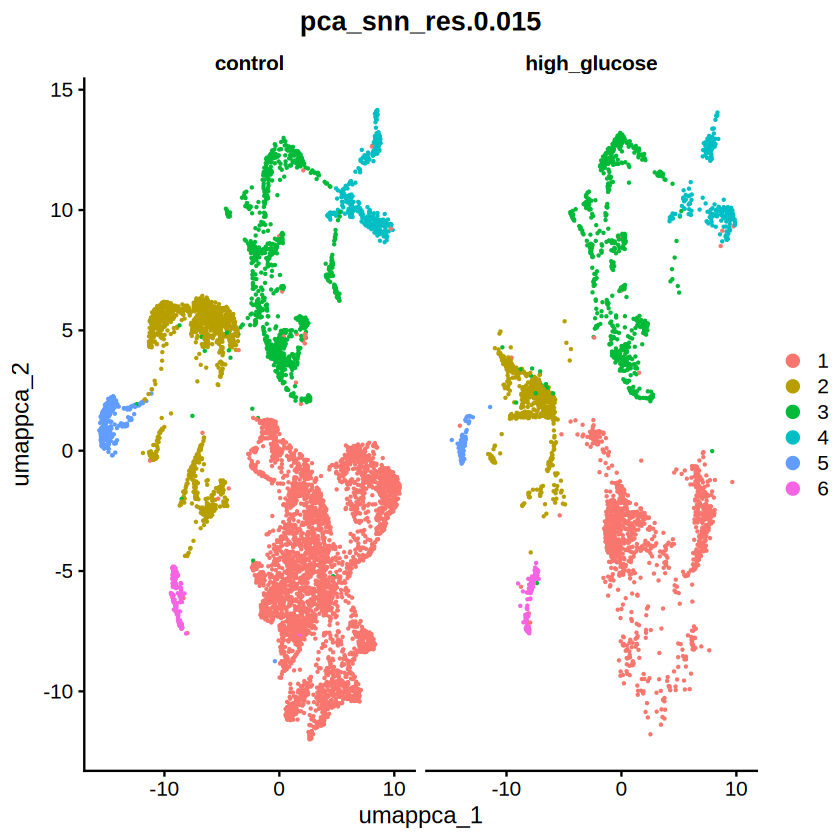

In [223]:
DimPlot(
  normalized_seurat,
  reduction = "umap_pca",
  group.by = 'pca_snn_res.0.015',
  split.by = 'orig.ident',
  combine = FALSE
)

**Figure 2.** Perform clustering analysis on both datasets.

In [39]:
saveRDS(normalized_seurat, file = here("seurat/clustering_before_integration.rds"))

## Data integration

In [41]:
integration_seurat <- readRDS(file = here("seurat/normalized_seurat.rds"))
integration_seurat

An object of class Seurat 
55695 features across 8740 samples within 2 assays 
Active assay: SCT (23174 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA

In [42]:
integration_seurat <- RunPCA(integration_seurat,
                     assay = 'SCT',
                     npcs = 30)

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 41 features requested have not been scaled (running reduction without them): CR848032.1, sycn.2, serpina1l, amy2a, serpina1, si:dkey-31i7.2, apom, fgb, serpinb1l4, muc5.2, leg1.1, muc5.3, cfhl4, zgc:92137, ttr, zgc:112265, cryba1b, si:ch211-131k2.2, CELA1 (1 of many).5, crp3, si:dkey-203a12.9, tmprss5, rom1a, crybb1l1, krt93, crygmx, si:dkey-239b22.2, apobb.1, shbg, si:dkey-202l22.6, plg, rhol, serpinf2a, cryba2a, grk1a, si:dkey-96g2.1, krt95, mybpc1, si:ch73-361h17.1, cnga1b, slc13a2”
PC_ 1 
Positive:  pfn1, spi1b, il1b, mmp9, fcer1gl, coro1a, npsn, ccr9a, ctss2.1, mmp13a.1 
	   mpx, mmp13a, si:dkey-102g19.3, lyz, gapdh, ncf1, CR318588.4, il6r, lect2l, lta4h 
	   cfbl, samsn1a, CABZ01001434.1, si:ch211-9d9.1, si:ch211-276a23.5, scinlb, si:ch73-343l4.8, il34, rac2, arpc1b 
Negative:  id1, hsp70.2, si:ch73-335l21.4, hsp70l, hsp70.3, her6, fosab, igfbp1a, dll4, cxcr4a 
	   hsp70.1, rgs5b, e

In [43]:
integration_seurat <- IntegrateLayers(integration_seurat,
                              normalization.method = "SCT",
                              method = HarmonyIntegration,
                              orig.reduction = "pca",
                              new.reduction = "harmony",
                              verbose = T
)

Warning message:
“HarmonyMatrix is deprecated and will be removed in the future from the API in the future”
Warning message:
“Warning: The parameters do_pca and npcs are deprecated. They will be ignored for this function call and please remove parameters do_pca and npcs and pass to harmony cell_embeddings directly.
This warning is displayed once per session.”
Warning message:
“Warning: The parameter tau is deprecated. It will be ignored for this function call and please remove parameter tau in future function calls. Advanced users can set value of parameter tau by using parameter .options and function harmony_options().
This warning is displayed once per session.”
Warning message:
“Warning: The parameter block.size is deprecated. It will be ignored for this function call and please remove parameter block.size in future function calls. Advanced users can set value of parameter block.size by using parameter .options and function harmony_options().
This warning is displayed once per sessi

## Clustering and viz of integrated dataset

In [44]:
integration_seurat <- FindNeighbors(integration_seurat,
                           reduction = "harmony",
                           graph.name = c("harmony_nn",
                                          "harmony_snn"),
                           k.param = 10,
                           dims = 1:30)

Computing nearest neighbor graph

Computing SNN



In [ ]:
integration_seurat <- FindClusters(integration_seurat,
                           graph.name = "harmony_snn",
                           resolution = c(0.02,0.023,0.025,0.027,0.03),
                           algorithm = 4)

In [58]:
head(integration_seurat@meta.data)


,orig.ident,nCount_RNA,nFeature_RNA,log1p_nCount_RNA,log1p_nFeature_RNA,pct_counts_in_top_20_genes,pct_counts_mt,outlier,mt_outlier,nCount_SCT,⋯,harmony_snn_res.0.03,harmony_snn_res.0.05,harmony_snn_res.0.1,harmony_snn_res.0.2,harmony_snn_res.0.3,harmony_snn_res.0.4,seurat_clusters,harmony_snn_res.0.023,harmony_snn_res.0.025,harmony_snn_res.0.027
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
control_AAACCCAAGACCAGCA-1,control,20307,3155,9.918770,8.057061,21.19466,3.210716,FALSE,FALSE,8725,⋯,1,1,1,1,3,3,1,1,1,1
control_AAACCCAAGCCTGGAA-1,control,9374,1963,9.145802,7.582738,19.70344,1.568167,FALSE,FALSE,8659,⋯,1,3,2,2,2,1,1,1,1,1
control_AAACCCACACACCTAA-1,control,10715,2117,9.279493,7.658228,21.42790,3.070462,FALSE,FALSE,8875,⋯,5,8,9,10,18,20,5,4,2,2
control_AAACCCACAGAACATA-1,control,6655,1959,8.803274,7.580700,21.59279,1.066867,FALSE,FALSE,7888,⋯,4,5,5,4,5,5,4,1,1,4
control_AAACCCATCATTGCGA-1,control,8002,1941,8.987572,7.571474,18.75781,2.211947,FALSE,FALSE,8232,⋯,4,5,5,15,17,19,4,1,1,4
control_AAACCCATCGAAGCAG-1,control,24797,3009,10.118518,8.009695,22.15187,2.903577,FALSE,FALSE,8190,⋯,3,2,8,9,9,10,3,2,2,2


In [54]:
## UMAP visualization
integration_seurat <- RunUMAP(integration_seurat,
                      reduction = "harmony",
                      dims = 1:30,
                      reduction.name = "umap_harmony",
                      min.dist = 0.5
)

17:53:20 UMAP embedding parameters a = 0.583 b = 1.334

17:53:20 Read 8740 rows and found 30 numeric columns

17:53:20 Using Annoy for neighbor search, n_neighbors = 30

17:53:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:53:21 Writing NN index file to temp file /tmp/RtmpTbWd4n/filedfdb4502dca8

17:53:21 Searching Annoy index using 1 thread, search_k = 3000

17:53:22 Annoy recall = 100%

17:53:23 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

17:53:23 Initializing from normalized Laplacian + noise (using RSpectra)

17:53:24 Commencing optimization for 500 epochs, with 364572 positive edges

17:53:29 Optimization finished



[[1]]

[[2]]


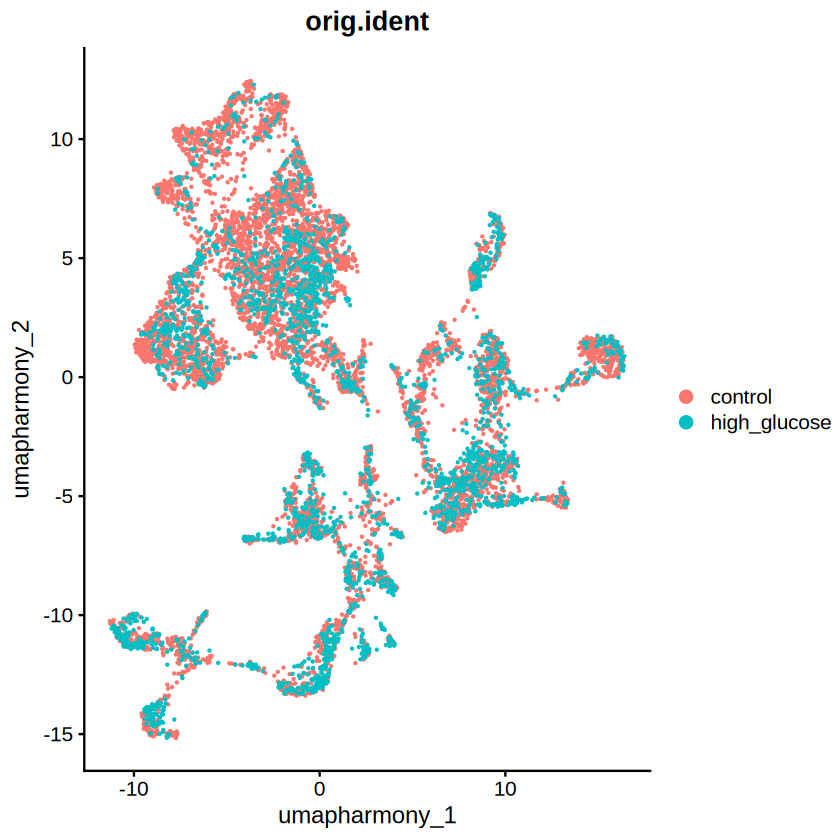

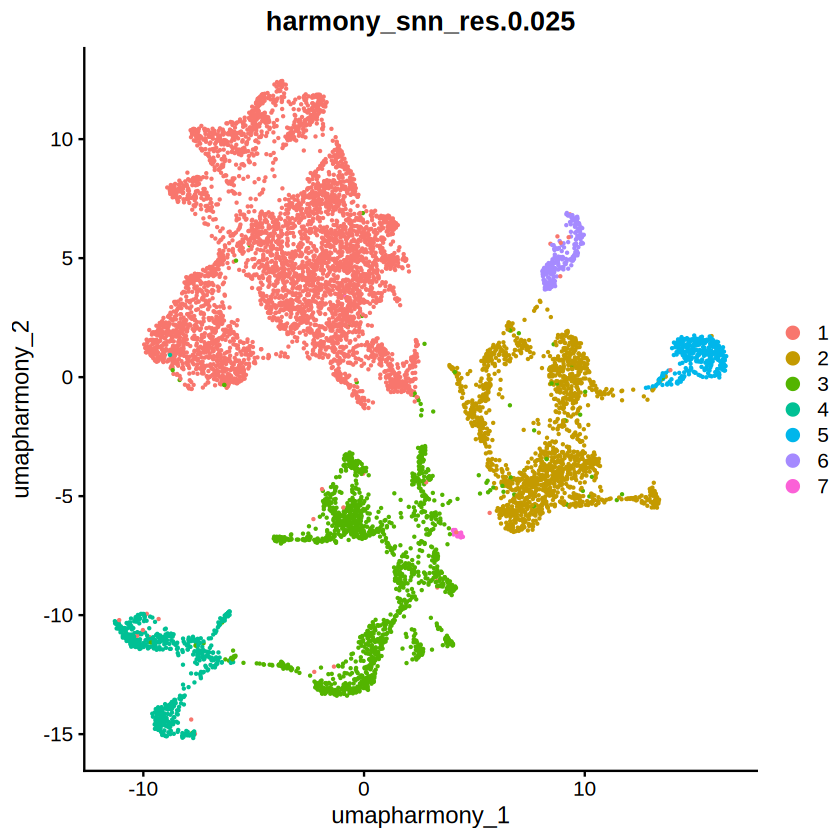

In [ ]:
DimPlot(
  integration_seurat,
  reduction = "umap_harmony",
  group.by = c('orig.ident',
               'harmony_snn_res.0.025'),
  combine = FALSE
)

**Figure 3.** Integrate the control and high glucose-treated datasets with Harmony.

In [59]:
saveRDS(integration_seurat, file = here("seurat/clustering_after_integration.rds"))

## DEG per cluster by condition

In [157]:
integration_seurat <- readRDS(file = here("seurat/clustering_after_integration.rds"))
integration_seurat

An object of class Seurat 
55695 features across 8740 samples within 2 assays 
Active assay: SCT (23174 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, harmony, umap_harmony

In [158]:
integration_seurat <- Seurat::SCTransform(integration_seurat,
    assay = 'RNA',
    new.assay.name = 'SCT',
    vst.flavor = "v2",
    variable.features.n = 3000,
    return.only.var.genes = TRUE,
    min_cells = 3,
    verbose = TRUE)

integration_seurat

Running SCTransform on assay: RNA

Running SCTransform on layer: counts

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 23714 by 8740

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Found 68 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 23714 genes

Computing corrected count matrix for 23714 genes

Calculating gene attributes

Wall clock passed: Time difference of 22.32856 secs

Determine variable features

Centering data matrix

Getting residuals for block 1(of 2) for counts dataset

Getting residuals for block 2(of 2) for counts dataset

Centering data matrix

Finished calculating residuals for counts

Warning message:
“Different cells and/or features from existing assay SCT”
Set default assay to SCT



An object of class Seurat 
56235 features across 8740 samples within 2 assays 
Active assay: SCT (23714 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, harmony, umap_harmony

In [172]:
clusters <- as.numeric(unique(integration_seurat$harmony_snn_res.0.025))
clusters

[1] 1 2 3 6 4 5 7

In [ ]:
cluster_DEGs <- list()

genes_list <- c()
results <- NULL

for (cluster in clusters) {
    cluster_subset <- subset(integration_seurat, subset = harmony_snn_res.0.025 == cluster)
    
    markers <- FindMarkers(cluster_subset,
                           ident.1 = "control",
                           ident.2 = "high_glucose",
                           group.by = "orig.ident",
                           test.use = "wilcox",
                           assay = "SCT",
                           slot = "data",
                           logfc.threshold = 0.25,
                           min.pct = 0.1)
    
    cluster_column <- rep(cluster, nrow(markers))
    genes_list <- c(genes_list, rownames(markers))
    markers_with_cluster <- cbind(cluster = cluster_column, markers)
    
    cluster_DEGs[[paste0("Cluster_", cluster)]] <- markers
    
    if (is.null(results)) {
        results <- markers_with_cluster
    } else {
        results <- rbind(results, markers_with_cluster)
    }
}


In [ ]:
final_results <- cbind(genes = genes_list, results)  %>% 
    tibble() %>% 
    filter(p_val_adj<0.05)

write.table(final_results, file = here("tables/high_glucose_vs_control_DEGs.tsv"), sep = "\t", quote = FALSE, row.names = FALSE, col.names = TRUE)

head(final_results)

genes,cluster,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
h1f0,1,0.000000e+00,-6.253412,0.154,0.959,0.000000e+00
histh1l,1,0.000000e+00,-5.718322,0.360,0.997,0.000000e+00
h1fx,1,0.000000e+00,-4.987630,0.171,0.772,0.000000e+00
h2afx1,1,0.000000e+00,-2.537145,0.759,0.994,0.000000e+00
cirbpb,1,3.325080e-236,-1.157699,0.987,1.000,7.885094e-232
hist2h2l,1,2.386156e-232,-2.711162,0.284,0.790,5.658529e-228


In [194]:
cluster_subset <- subset(integration_seurat, subset = harmony_snn_res.0.025 == 1)


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”


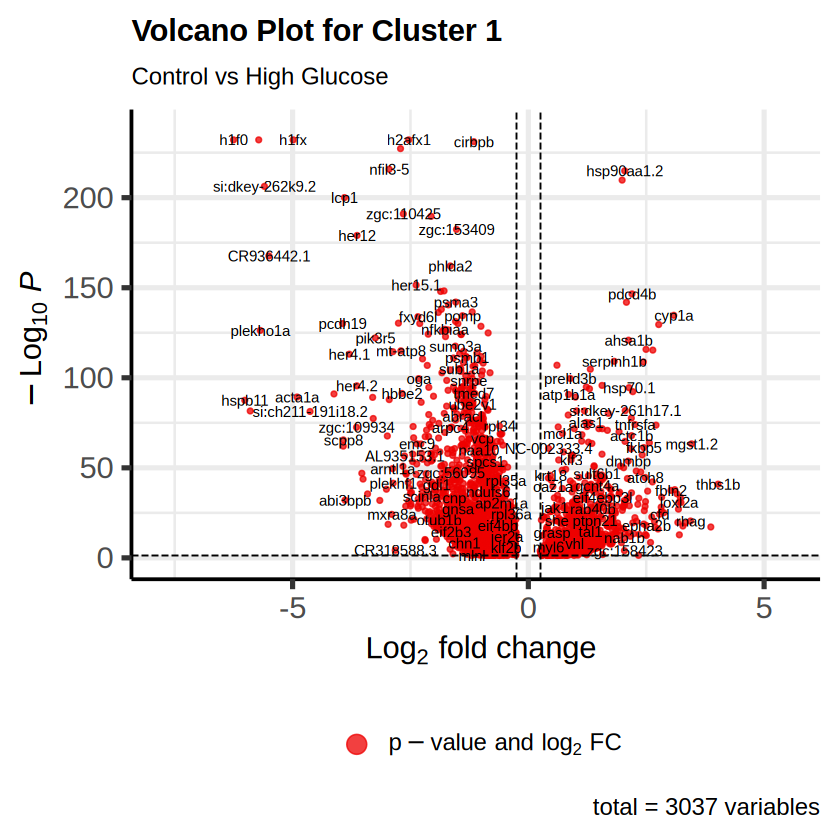

In [ ]:
# Subset Cluster 1 DEGs for plotting
cluster1_results <- final_results %>% filter(cluster == 1)

EnhancedVolcano(cluster1_results,
                lab = cluster1_results$genes,
                x = 'avg_log2FC',
                y = 'p_val_adj', 
                title = 'Volcano Plot for Cluster 1',
                subtitle = 'Control vs High Glucose',
                pCutoff = 0.05,
                FCcutoff = 0.25,
                pointSize = 1.0,
                labSize = 3.0,
                colAlpha = 0.75,
                legendPosition = 'bottom')

**Figure 4.1** Identify differentially expressed genes (DEGs) between the control and treated zebrafishes for each cell cluster. Example for cluster 1.

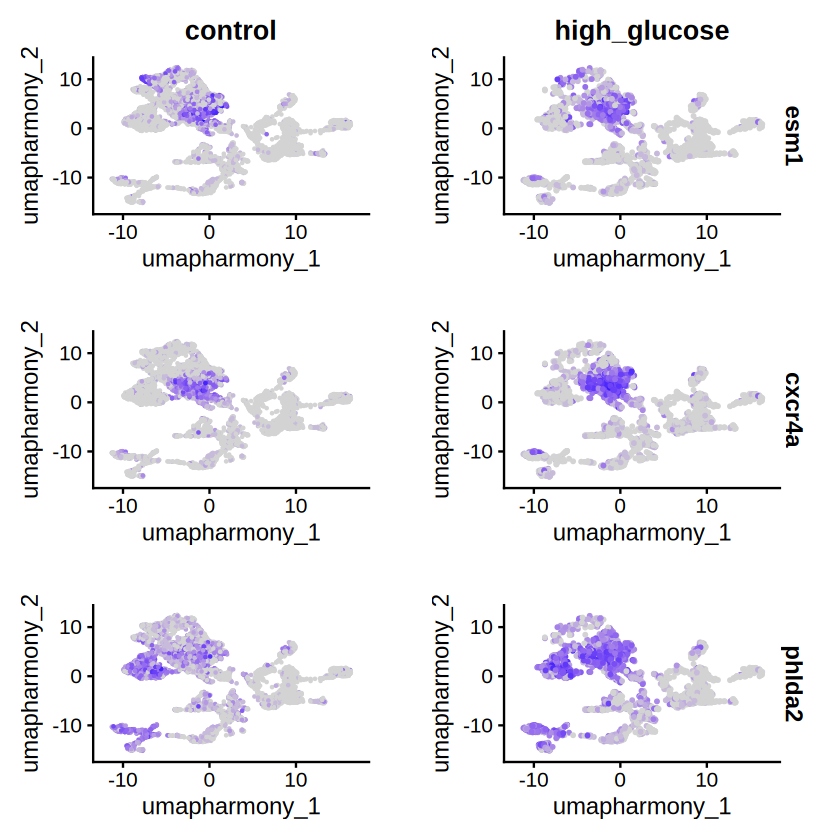

In [208]:
FeaturePlot(
    integration_seurat,
    features = c("esm1","cxcr4a","phlda2"),
    label = FALSE,
    ncol = 2,
    split.by = "orig.ident"
) +
NoLegend()

**Figure 4.2** Feature expression plots of esm1, cxcr4a, and phlda2 (DEGs) across conditions. The right panel represents the high glucose condition, demonstrating increased expression levels compared to the control condition on the left.

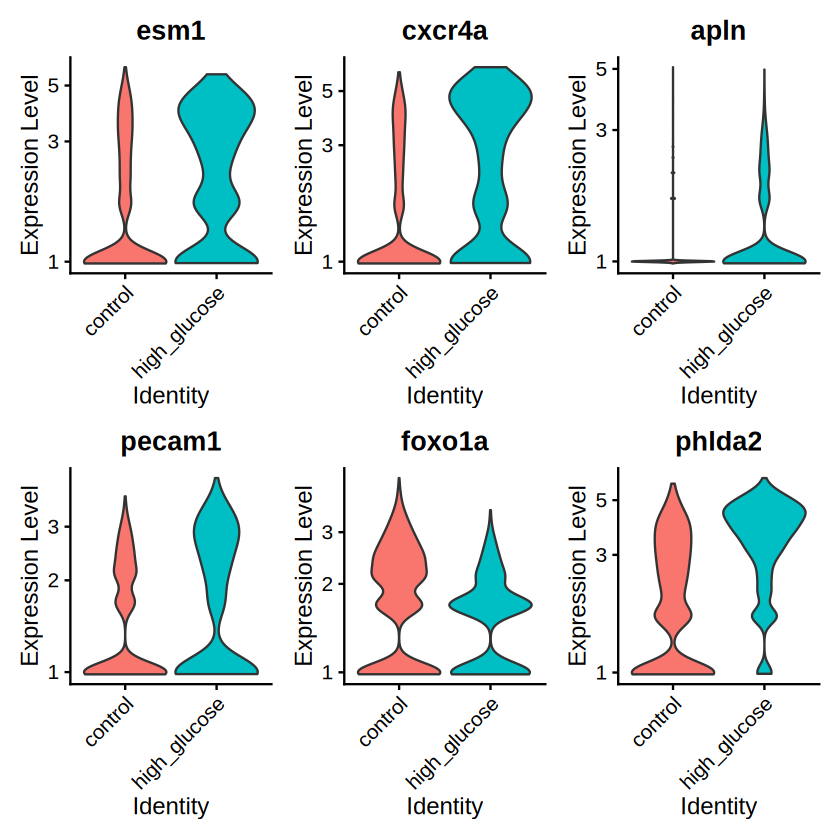

In [ ]:
VlnPlot(
    cluster_subset, 
    features = c("esm1","cxcr4a","apln","pecam1","foxo1a","phlda2"), 
    group.by = "orig.ident", 
    pt.size = 0,
    assay = "SCT",
    slot = "data",
    log = TRUE,
    ncol = 3
)

**Figure 4.3** Violin plots illustrating the expression distribution of esm1, cxcr4a, apln, pecam1, foxo1a, and phlda2 (DEGs) across experimental groups.